In [1]:
from __future__ import print_function

import glob
from os import path
from time import perf_counter as clock

from astropy.io import fits
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util



In [33]:
ppxf_dir   = "/home/carlos/Downloads/BADASS3-master/badass_data_files/indo_us_library/"
spec_path  = "/home/carlos/Desktop/pPXF(SDP)/Data/Annealing_Bin03/Binned_Spec/"
save_paths = glob.glob("/home/carlos/Desktop/pPXF(SDP)/Data/Annealing_Bin03/Bootstrapping/Bin*/")

In [4]:
def _fit(spec_name, galboots=None, bootstrapping=False):
    # Read a galaxy spectrum and define the wavelength range
    #
    file = spec_path + spec_name + ".fits"
    hdu = fits.open(file)
    gal_lin = hdu[1].data
    h1 = hdu[1].header

    lamRange1 = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(h1['NAXIS1'] - 1)])
    FWHM_gal = 2.71  # SAURON has an instrumental resolution FWHM of 4.2A.

    #READING THE VARIANCE/LENDO A VARIÂNCIA DO ESPECTRO

    var = hdu[2].data     #Read the variance/Lendo a variância
    h_var = hdu[2].header #Read the variance header/Lendo o header da variância
    lamRange_var = h_var['CRVAL1'] + np.array([0.,h_var['CDELT1']*(h_var['NAXIS1']-1)])

    # If the galaxy is at significant redshift, one should bring the galaxy
    # spectrum roughly to the rest-frame wavelength, before calling pPXF
    # (See Sec2.4 of Cappellari 2017). In practice there is no
    # need to modify the spectrum in any way, given that a red shift
    # corresponds to a linear shift of the log-rebinned spectrum.
    # One just needs to compute the wavelength range in the rest-frame
    # and adjust the instrumental resolution of the galaxy observations.
    # This is done with the following three commented lines:
    #
    z = 0.299  # Initial redshift estimate of the galaxy
    #z = 1.23 # Initial estimate of the galaxy redshift
    lamRange1 = lamRange1/(1+z) # Compute approximate restframe wavelength range
    FWHM_gal = FWHM_gal/(1+z)   # Adjust resolution in Angstrom
    lamRange_var = lamRange_var/(1+z)
    z = 0.00

    galaxy, logLam1, velscale = util.log_rebin(lamRange1, gal_lin)
    if bootstrapping is True:
        galaxy = galboots
        
    median_galaxy = np.median(galaxy)
    galaxy = galaxy/median_galaxy  # Normalize spectrum to avoid numerical issues
    lam = np.exp(logLam1)


    erro = np.sqrt(var) #1-sigma error from variance/1-sigma erro da variância
    erro, loglam_var, velscale_var = util.log_rebin(lamRange_var, erro)
    noise = erro/median_galaxy         #Normalizing the error/Normalizando o erro    

    # Read the list of filenames from the Single Stellar Population library
    # by Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/. A subset
    # of the library is included for this example with permission
    vazdekis = glob.glob(ppxf_dir + '/*.fits')
    FWHM_tem = 1.35  # Indu spectra  resolution
    velscale_ratio = 2  # adopts 2x higher spectral sampling for templates than for galaxy
    
    
    # Extract the wavelength range and logarithmically rebin one spectrum
    # to a velocity scale 2x smaller than the SAURON galaxy spectrum, to determine
    # the size needed for the array which will contain the template spectra.
    #
    hdu = fits.open(vazdekis[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    lamRange2 = h2['CRVAL1'] + np.array([0., h2['CDELT1']*(h2['NAXIS1'] - 1)])
    sspNew, logLam2, velscale_temp = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio)
    templates = np.empty((sspNew.size, len(vazdekis)))
    
    # Convolve the whole Vazdekis library of spectral templates
    # with the quadratic difference between the SAURON and the
    # Vazdekis instrumental resolution. Logarithmically rebin
    # and store each template as a column in the array TEMPLATES.

    # Quadratic sigma difference in pixels Vazdekis --> SAURON
    # The formula below is rigorously valid if the shapes of the
    # instrumental spectral profiles are well approximated by Gaussians.
    #
    FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2)
    sigma = FWHM_dif/2.355/h2['CDELT1']  # Sigma difference in pixels

    for j, file in enumerate(vazdekis):
        hdu = fits.open(file)
        ssp = hdu[0].data
        ssp = ndimage.gaussian_filter1d(ssp, sigma)
        sspNew, logLam2, velscale_temp = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio)
        templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates
        
        # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below (see above).
    #
    c = 299792.458
    dv = (np.mean(logLam2[:velscale_ratio]) - logLam1[0])*c  # km/s

    goodPixels = util.determine_goodpixels(logLam1, lamRange2, z)
    # Here the actual fit starts. The best fit is plotted on the screen.
# Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.

    vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
    start = [vel, 200.]  # (km/s), starting guess for [V, sigma]


    pp = ppxf(templates, galaxy, noise, velscale, start,lam=lam,
              goodpixels=goodPixels, plot=True, moments=2,mdegree=6,
              degree=6, vsyst=dv, velscale_ratio=velscale_ratio, bias=0.)
    print("Formal errors:")
    print("     dV    dsigma   dh3      dh4")
    print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))
    
    out = pp.bestfit, pp.galaxy, pp.sol, pp.noise, goodPixels
    return out

In [51]:
def bootstrap_fig(save_path, spec_name, it,
                                 galboots=None):
    fig = plt.figure()
    
    if galboots is not None:
        out = _fit(spec_name, galboots=galboots, bootstrapping=True)
    else:
        out = _fit(spec_name)
    sols = out[2]
    
    textx = 500
    texty = 1.2
    sols = out[2]
    textx = [375, 385]
    texty = 1.4
    texty2 = 1.3
    fs = 20
    plt.text(textx[0], texty, r'V [km/s]', size=fs)
    plt.text(textx[1], texty, r'$\sigma$ [km/s]', size=fs)

    plt.text(textx[0], texty2, str(int(sols[0])), size=fs)
    plt.text(textx[1], texty2, str(int(sols[1])), size=fs)

    fig.set_size_inches(18.5, 10.5)
    plt.savefig(save_path+spec_name+'_iteration_%d'%it,dpi=100)
    plt.close()
    
    return out
    
    



def bootstrap(nit, save_path, spec_name):
# basically bootstrap the noise!
    # Do one fit with flat noise, then save the best fit spectrum and the residuals.
    # Then, iterate ~200 times. For these iterations, set bias = 0.0. Each iteration, for each pixel, use the spectrum
    # value as the center of a gaussian and use the residuals at that pixel value as the width of the gaussian. Draw
    # from the resultant distribution to make the new noise. For each iteration, save the output V, sigma, h3, h4, and
    # print each spectrum so that we can see it evolving (it should look more like a real spectrum, rather than smooth
    # curve without lines)
    out = bootstrap_fig(save_path, spec_name, 0)
    sols = out[2]
    
    sol_matrix = np.zeros(shape=(2, nit))
    resid = out[1] - out[0]  # galaxy - bestfit = resid, from ppxf()
    #resid = resid[out[4]]    # resid[goodPixels]
    orig_noise = out[3]      # original noise of spectrum
    #orig_noise = orig_noise[out[4]] # original_noise[goodPixels]
    
    std_dev = np.sqrt(orig_noise**2 + resid**2)  # the residual noise and spectral noise added in quadrature
    bfit = out[0]
    orig = out[2]
    
    counter = 0
    
    for i in range(nit):
        #print(counter)
        new_gal = np.random.normal(loc=bfit, scale=std_dev)
        
        counter += 1
        new_gal = np.asarray(new_gal)
        #print(new_gal.shape)

        out = bootstrap_fig(save_path, spec_name, counter, galboots=new_gal)
        sols = out[2]
        sol_matrix[:, counter - 1] = sols  # save solutions
        plt.close()
        
    
    return sol_matrix, orig

def plot_boots(nit, sol_matrix, orig_fit,
                  save_path):
    iters=nit
    fig = plt.figure(figsize=(1.4, 3.8))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    axes = [ax1, ax2]
    labels = [r'V', r'$\sigma$',]
    for i in range(len(sol_matrix)):  # 4
        percs = np.percentile(sol_matrix[i], [0.3, 2.4, 16.0, 50.0, 84.0, 97.6, 99.7])  # median, 1,2,3 sigma
        t_x = min(sol_matrix[i])
        t_y1 = 0.02
        t_y2 = 0.03
        t_y3 = 0.04
        # axes[i].text(t_x, t_y3,)

        axes[i].axvline(x=orig_fit[i], color='k', linestyle='--', lw=2, label='Original fit')

        axes[i].hist(sol_matrix[i], bins=50, histtype="step", weights=[1. / iters] * len(sol_matrix[i]),
                     color='k', lw=2, label=labels[i])
        axes[i].axvline(x=percs[3], color='b', linestyle='--', lw=2, label='Median')
        axes[i].axvline(x=np.mean(sol_matrix[i]), color='b', ls='-', lw=2, label='Mean')

        axes[i].axvspan(percs[0], percs[6], color='b', alpha=0.1)  # 3 sigma
        axes[i].axvspan(percs[1], percs[5], color='b', alpha=0.1)  # 2 sigma
        axes[i].axvspan(percs[2], percs[4], color='b', alpha=0.1)  # 1 sigma
        axes[i].legend(numpoints=1, loc='upper left', prop={'size': 10})

        fig.set_size_inches(18.5, 6.5)
        # plt.text()

        #print(percs)
        #print(orig, 'orig')
    axes[0].set_xlabel(r'V [km/s]')
    axes[1].set_xlabel(r'$\sigma$ [km/s]')
    plt.savefig (save_path+'Resume_%d_iterations'%iters)  # , dpi=500)
    #plt.show()
    plt.close()
    

In [ ]:
nit = 200
for i in range(len(save_paths)):
    spec_name = ("Bin"+save_paths[i][len(save_paths[i])-2])
    sol_matrix, orig_fit = bootstrap(nit=nit, save_path=save_paths[i], spec_name=spec_name)
    plot_boots(nit=nit, sol_matrix=sol_matrix, orig_fit=orig_fit, save_path=save_paths[i])
    
    np.savetxt(save_paths[i]+"Sol_Matrix.txt", np.column_stack([sol_matrix[0],sol_matrix[1]]),
               header="Vel [km/s] \t Disp [km/s]",
               fmt="%.5e \t %.5e")

 Best Fit:       Vel     sigma
 comp.  0:       173       191
chi2/DOF: 1.33
method = capfit; Jac calls: 9; Func calls: 86; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  5 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      35      46
 Best Fit:       Vel     sigma
 comp.  0:       164        98
chi2/DOF: 0.002273
method = capfit; Jac calls: 6; Func calls: 56; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  6 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      28      40
 Best Fit:       Vel     sigma
 comp.  0:       215       190
chi2/DOF: 0.002418
method = capfit; Jac calls: 9; Func calls: 90; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  4 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      36      43
 Best Fit:       Vel     sigma
 comp.  0:       195       119
chi2/DOF: 0.002386
method = capfit; Jac calls: 6; Func calls: 62; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  4 / 50
Formal errors:
     dV    dsi

 Best Fit:       Vel     sigma
 comp.  0:       171       135
chi2/DOF: 0.002624
method = capfit; Jac calls: 7; Func calls: 73; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  3 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      42      50
 Best Fit:       Vel     sigma
 comp.  0:       160       222
chi2/DOF: 0.002474
method = capfit; Jac calls: 5; Func calls: 52; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  5 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      37      46
 Best Fit:       Vel     sigma
 comp.  0:       192       128
chi2/DOF: 0.002586
method = capfit; Jac calls: 9; Func calls: 90; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  4 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      36      58
 Best Fit:       Vel     sigma
 comp.  0:       134       137
chi2/DOF: 0.002508
method = capfit; Jac calls: 10; Func calls: 97; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  3 / 50
Formal errors:
     dV  

 Best Fit:       Vel     sigma
 comp.  0:       168         1
chi2/DOF: 0.002426
method = capfit; Jac calls: 10; Func calls: 103; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  3 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      21 1.4e+03
 Best Fit:       Vel     sigma
 comp.  0:       102       244
chi2/DOF: 0.002302
method = capfit; Jac calls: 7; Func calls: 73; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  5 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      46      59
 Best Fit:       Vel     sigma
 comp.  0:       184       165
chi2/DOF: 0.002609
method = capfit; Jac calls: 6; Func calls: 63; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  4 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      43      60
 Best Fit:       Vel     sigma
 comp.  0:       188       169
chi2/DOF: 0.002196
method = capfit; Jac calls: 7; Func calls: 73; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  5 / 50
Formal errors:
     dV 

 Best Fit:       Vel     sigma
 comp.  0:       237       118
chi2/DOF: 0.002262
method = capfit; Jac calls: 21; Func calls: 197; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  5 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      28      42
 Best Fit:       Vel     sigma
 comp.  0:       218       170
chi2/DOF: 0.002362
method = capfit; Jac calls: 7; Func calls: 72; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  5 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      50      59
 Best Fit:       Vel     sigma
 comp.  0:       217       111
chi2/DOF: 0.002096
method = capfit; Jac calls: 11; Func calls: 107; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      30      43
 Best Fit:       Vel     sigma
 comp.  0:       165       344
chi2/DOF: 0.002402
method = capfit; Jac calls: 8; Func calls: 78; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  6 / 50
Formal errors:
     d

 Best Fit:       Vel     sigma
 comp.  0:       152       195
chi2/DOF: 0.002349
method = capfit; Jac calls: 11; Func calls: 104; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  3 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      32      43
 Best Fit:       Vel     sigma
 comp.  0:       258       148
chi2/DOF: 0.002296
method = capfit; Jac calls: 9; Func calls: 90; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  5 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      30      47
 Best Fit:       Vel     sigma
 comp.  0:       167       108
chi2/DOF: 0.001929
method = capfit; Jac calls: 7; Func calls: 71; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  6 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      30      44
 Best Fit:       Vel     sigma
 comp.  0:       166       119
chi2/DOF: 0.002452
method = capfit; Jac calls: 8; Func calls: 80; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  4 / 50
Formal errors:
     dV 

 Best Fit:       Vel     sigma
 comp.  0:       161       277
chi2/DOF: 0.002389
method = capfit; Jac calls: 7; Func calls: 70; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  5 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      46      59
 Best Fit:       Vel     sigma
 comp.  0:       158       180
chi2/DOF: 0.002535
method = capfit; Jac calls: 6; Func calls: 56; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      43      50
 Best Fit:       Vel     sigma
 comp.  0:       156       149
chi2/DOF: 0.002463
method = capfit; Jac calls: 6; Func calls: 64; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  6 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      37      51
 Best Fit:       Vel     sigma
 comp.  0:       358       202
chi2/DOF: 0.002773
method = capfit; Jac calls: 12; Func calls: 119; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  1 / 50
Formal errors:
     dV 

 Best Fit:       Vel     sigma
 comp.  0:       157       137
chi2/DOF: 0.002277
method = capfit; Jac calls: 9; Func calls: 87; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  3 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      29      40
 Best Fit:       Vel     sigma
 comp.  0:       226       229
chi2/DOF: 0.002379
method = capfit; Jac calls: 11; Func calls: 107; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      45      50
 Best Fit:       Vel     sigma
 comp.  0:        69        70
chi2/DOF: 0.002523
method = capfit; Jac calls: 8; Func calls: 78; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  6 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      31      48
 Best Fit:       Vel     sigma
 comp.  0:       155       139
chi2/DOF: 0.002432
method = capfit; Jac calls: 10; Func calls: 100; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  4 / 50
Formal errors:
     d

 Best Fit:       Vel     sigma
 comp.  0:       138       249
chi2/DOF: 0.0001464
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      11      16
 Best Fit:       Vel     sigma
 comp.  0:       147       252
chi2/DOF: 0.0001313
method = capfit; Jac calls: 6; Func calls: 56; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  11 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      12      15
 Best Fit:       Vel     sigma
 comp.  0:       146       239
chi2/DOF: 0.0001509
method = capfit; Jac calls: 6; Func calls: 58; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      12      15
 Best Fit:       Vel     sigma
 comp.  0:       139       236
chi2/DOF: 0.0001461
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
   

 Best Fit:       Vel     sigma
 comp.  0:       134       250
chi2/DOF: 0.0001415
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      12      17
 Best Fit:       Vel     sigma
 comp.  0:       123       228
chi2/DOF: 0.0001768
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      15      16
 Best Fit:       Vel     sigma
 comp.  0:       161       254
chi2/DOF: 0.0001491
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      15      16
 Best Fit:       Vel     sigma
 comp.  0:       139       248
chi2/DOF: 0.0001355
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
    

 Best Fit:       Vel     sigma
 comp.  0:       142       248
chi2/DOF: 0.000124
method = capfit; Jac calls: 6; Func calls: 59; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      10      13
 Best Fit:       Vel     sigma
 comp.  0:       131       242
chi2/DOF: 0.0001228
method = capfit; Jac calls: 6; Func calls: 58; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      15      14
 Best Fit:       Vel     sigma
 comp.  0:       157       229
chi2/DOF: 0.0001368
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      11      14
 Best Fit:       Vel     sigma
 comp.  0:       125       257
chi2/DOF: 0.0001291
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  5 / 50
Formal errors:
     d

 Best Fit:       Vel     sigma
 comp.  0:       153       271
chi2/DOF: 0.0001295
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  5 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      14      14
 Best Fit:       Vel     sigma
 comp.  0:       135       238
chi2/DOF: 0.0001517
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      11      15
 Best Fit:       Vel     sigma
 comp.  0:       156       273
chi2/DOF: 0.0001257
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      11      15
 Best Fit:       Vel     sigma
 comp.  0:       147       271
chi2/DOF: 0.0001255
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
    

 Best Fit:       Vel     sigma
 comp.  0:       130       254
chi2/DOF: 0.0001368
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      12      16
 Best Fit:       Vel     sigma
 comp.  0:       126       259
chi2/DOF: 0.0001301
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      11      15
 Best Fit:       Vel     sigma
 comp.  0:       144       255
chi2/DOF: 0.0001327
method = capfit; Jac calls: 7; Func calls: 65; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      11      15
 Best Fit:       Vel     sigma
 comp.  0:       140       274
chi2/DOF: 0.0001311
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     

 Best Fit:       Vel     sigma
 comp.  0:       136       236
chi2/DOF: 0.0001405
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  6 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      11      13
 Best Fit:       Vel     sigma
 comp.  0:       137       264
chi2/DOF: 0.0001463
method = capfit; Jac calls: 6; Func calls: 58; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      11      17
 Best Fit:       Vel     sigma
 comp.  0:       133       237
chi2/DOF: 0.0001295
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      14      15
 Best Fit:       Vel     sigma
 comp.  0:       129       249
chi2/DOF: 0.0001219
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     

 Best Fit:       Vel     sigma
 comp.  0:       134       242
chi2/DOF: 1.979e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     9.6      12
 Best Fit:       Vel     sigma
 comp.  0:       141       226
chi2/DOF: 2.023e-05
method = capfit; Jac calls: 8; Func calls: 75; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  6 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      12      13
 Best Fit:       Vel     sigma
 comp.  0:       164       220
chi2/DOF: 1.887e-05
method = capfit; Jac calls: 5; Func calls: 50; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     9.4      12
 Best Fit:       Vel     sigma
 comp.  0:       124       227
chi2/DOF: 1.965e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     

 Best Fit:       Vel     sigma
 comp.  0:       139       220
chi2/DOF: 2.208e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      13      14
 Best Fit:       Vel     sigma
 comp.  0:       152       220
chi2/DOF: 1.979e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     9.9      13
 Best Fit:       Vel     sigma
 comp.  0:       141       198
chi2/DOF: 1.949e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      16      12
 Best Fit:       Vel     sigma
 comp.  0:       159       223
chi2/DOF: 2.07e-05
method = capfit; Jac calls: 5; Func calls: 50; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV

 Best Fit:       Vel     sigma
 comp.  0:       145       230
chi2/DOF: 2.199e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  5 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     9.6      13
 Best Fit:       Vel     sigma
 comp.  0:       150       243
chi2/DOF: 2.077e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      12      14
 Best Fit:       Vel     sigma
 comp.  0:       124       192
chi2/DOF: 2.188e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     9.4      13
 Best Fit:       Vel     sigma
 comp.  0:       141       221
chi2/DOF: 1.938e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     d

 Best Fit:       Vel     sigma
 comp.  0:       151       217
chi2/DOF: 2.162e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     9.8      13
 Best Fit:       Vel     sigma
 comp.  0:       138       240
chi2/DOF: 1.789e-05
method = capfit; Jac calls: 5; Func calls: 49; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      12      13
 Best Fit:       Vel     sigma
 comp.  0:       140       221
chi2/DOF: 1.87e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  11 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      10      12
 Best Fit:       Vel     sigma
 comp.  0:       146       233
chi2/DOF: 2.291e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     

 Best Fit:       Vel     sigma
 comp.  0:       153       219
chi2/DOF: 2.102e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      10      14
 Best Fit:       Vel     sigma
 comp.  0:       133       238
chi2/DOF: 1.934e-05
method = capfit; Jac calls: 6; Func calls: 56; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      10      13
 Best Fit:       Vel     sigma
 comp.  0:       135       230
chi2/DOF: 2.065e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     9.4      12
 Best Fit:       Vel     sigma
 comp.  0:       155       255
chi2/DOF: 2.087e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     

 Best Fit:       Vel     sigma
 comp.  0:       143       252
chi2/DOF: 2.287e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      10      14
 Best Fit:       Vel     sigma
 comp.  0:       149       216
chi2/DOF: 2.009e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     9.5      13
 Best Fit:       Vel     sigma
 comp.  0:       161       245
chi2/DOF: 1.806e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     9.6      13
 Best Fit:       Vel     sigma
 comp.  0:       156       234
chi2/DOF: 1.953e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     d

 Best Fit:       Vel     sigma
 comp.  0:       131       218
chi2/DOF: 2.3e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      11      10
 Best Fit:       Vel     sigma
 comp.  0:       148       225
chi2/DOF: 2.274e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  11 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      12      11
 Best Fit:       Vel     sigma
 comp.  0:       146       233
chi2/DOF: 2.401e-05
method = capfit; Jac calls: 6; Func calls: 58; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     8.7      12
 Best Fit:       Vel     sigma
 comp.  0:       154       236
chi2/DOF: 2.406e-05
method = capfit; Jac calls: 6; Func calls: 59; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     

 Best Fit:       Vel     sigma
 comp.  0:       157       215
chi2/DOF: 2.136e-05
method = capfit; Jac calls: 6; Func calls: 56; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     7.6      11
 Best Fit:       Vel     sigma
 comp.  0:       147       223
chi2/DOF: 2.129e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     8.2      11
 Best Fit:       Vel     sigma
 comp.  0:       141       229
chi2/DOF: 1.839e-05
method = capfit; Jac calls: 6; Func calls: 58; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     7.4      10
 Best Fit:       Vel     sigma
 comp.  0:       150       231
chi2/DOF: 2.025e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
    

 Best Fit:       Vel     sigma
 comp.  0:       142       213
chi2/DOF: 2.419e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  12 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      10      13
 Best Fit:       Vel     sigma
 comp.  0:       145       211
chi2/DOF: 2.127e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     7.6      11
 Best Fit:       Vel     sigma
 comp.  0:       150       218
chi2/DOF: 2.04e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     7.6      10
 Best Fit:       Vel     sigma
 comp.  0:       143       215
chi2/DOF: 2.542e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     

 Best Fit:       Vel     sigma
 comp.  0:       154       213
chi2/DOF: 2.194e-05
method = capfit; Jac calls: 6; Func calls: 56; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     7.6      11
 Best Fit:       Vel     sigma
 comp.  0:       147       224
chi2/DOF: 2.155e-05
method = capfit; Jac calls: 6; Func calls: 56; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     8.9      11
 Best Fit:       Vel     sigma
 comp.  0:       143       216
chi2/DOF: 2.135e-05
method = capfit; Jac calls: 5; Func calls: 49; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  11 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     8.1      10
 Best Fit:       Vel     sigma
 comp.  0:       148       216
chi2/DOF: 2.133e-05
method = capfit; Jac calls: 5; Func calls: 49; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  11 / 50
Formal errors:
    

 Best Fit:       Vel     sigma
 comp.  0:       143       216
chi2/DOF: 2.09e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  11 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      11      11
 Best Fit:       Vel     sigma
 comp.  0:       141       235
chi2/DOF: 1.984e-05
method = capfit; Jac calls: 5; Func calls: 50; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      13      11
 Best Fit:       Vel     sigma
 comp.  0:       134       235
chi2/DOF: 2.472e-05
method = capfit; Jac calls: 6; Func calls: 58; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     9.1      13
 Best Fit:       Vel     sigma
 comp.  0:       142       228
chi2/DOF: 2.077e-05
method = capfit; Jac calls: 5; Func calls: 50; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  12 / 50
Formal errors:
    

 Best Fit:       Vel     sigma
 comp.  0:       154       208
chi2/DOF: 2.135e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     7.7      11
 Best Fit:       Vel     sigma
 comp.  0:       139       213
chi2/DOF: 2.068e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     7.6      11
 Best Fit:       Vel     sigma
 comp.  0:       145       219
chi2/DOF: 2.218e-05
method = capfit; Jac calls: 6; Func calls: 59; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  11 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     8.2      12
 Best Fit:       Vel     sigma
 comp.  0:       152       211
chi2/DOF: 2.197e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  6 / 50
Formal errors:
     

 Best Fit:       Vel     sigma
 comp.  0:       151       228
chi2/DOF: 2.062e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     8.3      11
 Best Fit:       Vel     sigma
 comp.  0:       148       210
chi2/DOF: 2.114e-05
method = capfit; Jac calls: 6; Func calls: 59; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     7.9      11
 Best Fit:       Vel     sigma
 comp.  0:       154       209
chi2/DOF: 1.975e-05
method = capfit; Jac calls: 6; Func calls: 58; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     7.2     9.6
 Best Fit:       Vel     sigma
 comp.  0:       160       220
chi2/DOF: 2.166e-05
method = capfit; Jac calls: 6; Func calls: 56; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
    

 Best Fit:       Vel     sigma
 comp.  0:       158       217
chi2/DOF: 1.269e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     7.9      11
 Best Fit:       Vel     sigma
 comp.  0:       136       223
chi2/DOF: 1.372e-05
method = capfit; Jac calls: 7; Func calls: 65; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      11      10
 Best Fit:       Vel     sigma
 comp.  0:       142       218
chi2/DOF: 1.324e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     7.2      10
 Best Fit:       Vel     sigma
 comp.  0:       167       210
chi2/DOF: 1.585e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
    

 Best Fit:       Vel     sigma
 comp.  0:       139       224
chi2/DOF: 1.46e-05
method = capfit; Jac calls: 6; Func calls: 56; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     8.2      11
 Best Fit:       Vel     sigma
 comp.  0:       149       224
chi2/DOF: 1.413e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      12      11
 Best Fit:       Vel     sigma
 comp.  0:       148       222
chi2/DOF: 1.328e-05
method = capfit; Jac calls: 6; Func calls: 56; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  12 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     8.6      12
 Best Fit:       Vel     sigma
 comp.  0:       148       245
chi2/DOF: 1.344e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  13 / 50
Formal errors:
    

 Best Fit:       Vel     sigma
 comp.  0:       140       243
chi2/DOF: 1.361e-05
method = capfit; Jac calls: 6; Func calls: 59; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  13 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      12      12
 Best Fit:       Vel     sigma
 comp.  0:       135       229
chi2/DOF: 1.448e-05
method = capfit; Jac calls: 5; Func calls: 50; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     9.1      11
 Best Fit:       Vel     sigma
 comp.  0:       147       202
chi2/DOF: 1.318e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  13 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     7.4     9.7
 Best Fit:       Vel     sigma
 comp.  0:       141       218
chi2/DOF: 1.33e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
    

 Best Fit:       Vel     sigma
 comp.  0:       151       221
chi2/DOF: 1.411e-05
method = capfit; Jac calls: 6; Func calls: 59; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  11 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     9.5      11
 Best Fit:       Vel     sigma
 comp.  0:       136       230
chi2/DOF: 1.329e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  12 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     8.4      11
 Best Fit:       Vel     sigma
 comp.  0:       141       219
chi2/DOF: 1.401e-05
method = capfit; Jac calls: 5; Func calls: 49; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     7.6      10
 Best Fit:       Vel     sigma
 comp.  0:       138       228
chi2/DOF: 1.427e-05
method = capfit; Jac calls: 7; Func calls: 65; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
    

 Best Fit:       Vel     sigma
 comp.  0:       150       236
chi2/DOF: 1.449e-05
method = capfit; Jac calls: 6; Func calls: 56; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
       9      12
 Best Fit:       Vel     sigma
 comp.  0:       145       221
chi2/DOF: 1.568e-05
method = capfit; Jac calls: 6; Func calls: 56; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     8.6      11
 Best Fit:       Vel     sigma
 comp.  0:       153       235
chi2/DOF: 1.357e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     7.8      11
 Best Fit:       Vel     sigma
 comp.  0:       145       233
chi2/DOF: 1.531e-05
method = capfit; Jac calls: 5; Func calls: 50; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     

 Best Fit:       Vel     sigma
 comp.  0:       139       208
chi2/DOF: 1.369e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
       9     9.9
 Best Fit:       Vel     sigma
 comp.  0:       145       220
chi2/DOF: 1.176e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  12 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     8.7     9.6
 Best Fit:       Vel     sigma
 comp.  0:       143       225
chi2/DOF: 1.412e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     dV    dsigma   dh3      dh4
     8.4      11
 Best Fit:       Vel     sigma
 comp.  0:       136       222
chi2/DOF: 1.306e-05
method = capfit; Jac calls: 6; Func calls: 56; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
    

 Best Fit:       Vel     sigma
 comp.  0:       155       210
chi2/DOF: 1.833e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      11      14
 Best Fit:       Vel     sigma
 comp.  0:       172       208
chi2/DOF: 2.285e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      19      18
 Best Fit:       Vel     sigma
 comp.  0:       155       201
chi2/DOF: 1.955e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      10      15
 Best Fit:       Vel     sigma
 comp.  0:       154       206
chi2/DOF: 1.94e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  6 / 50
Formal errors:
     dV

 Best Fit:       Vel     sigma
 comp.  0:       173       232
chi2/DOF: 1.829e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  6 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      13      17
 Best Fit:       Vel     sigma
 comp.  0:       131       208
chi2/DOF: 1.682e-05
method = capfit; Jac calls: 6; Func calls: 62; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      14      15
 Best Fit:       Vel     sigma
 comp.  0:       147       200
chi2/DOF: 1.882e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      12      16
 Best Fit:       Vel     sigma
 comp.  0:       165       232
chi2/DOF: 1.948e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     

 Best Fit:       Vel     sigma
 comp.  0:       167       240
chi2/DOF: 1.874e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      18      18
 Best Fit:       Vel     sigma
 comp.  0:       185       183
chi2/DOF: 1.631e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      11      14
 Best Fit:       Vel     sigma
 comp.  0:       144       199
chi2/DOF: 2.1e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      13      16
 Best Fit:       Vel     sigma
 comp.  0:       170       205
chi2/DOF: 1.902e-05
method = capfit; Jac calls: 5; Func calls: 48; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV

 Best Fit:       Vel     sigma
 comp.  0:       163       202
chi2/DOF: 1.758e-05
method = capfit; Jac calls: 4; Func calls: 38; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      19      16
 Best Fit:       Vel     sigma
 comp.  0:       172       215
chi2/DOF: 2.052e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      13      17


In [43]:
i=6
("Bin"+save_paths[i][len(save_paths[i])-2])
save_paths

['/home/carlos/Desktop/pPXF(SDP)/Data/Annealing_Bin03/Bootstrapping/Bin7/',
 '/home/carlos/Desktop/pPXF(SDP)/Data/Annealing_Bin03/Bootstrapping/Bin0/',
 '/home/carlos/Desktop/pPXF(SDP)/Data/Annealing_Bin03/Bootstrapping/Bin3/',
 '/home/carlos/Desktop/pPXF(SDP)/Data/Annealing_Bin03/Bootstrapping/Bin1/',
 '/home/carlos/Desktop/pPXF(SDP)/Data/Annealing_Bin03/Bootstrapping/Bin2/',
 '/home/carlos/Desktop/pPXF(SDP)/Data/Annealing_Bin03/Bootstrapping/Bin4/',
 '/home/carlos/Desktop/pPXF(SDP)/Data/Annealing_Bin03/Bootstrapping/Bin6/',
 '/home/carlos/Desktop/pPXF(SDP)/Data/Annealing_Bin03/Bootstrapping/Bin5/']

In [193]:
sol_matrix, orig_fit = bootstrap(nit=100, save_path=save_path, spec_name=spec_name)

 Best Fit:       Vel     sigma
 comp.  0:       136       176
chi2/DOF: 1.169
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      12      16
 Best Fit:       Vel     sigma
 comp.  0:       159       159
chi2/DOF: 5.727e-05
method = capfit; Jac calls: 10; Func calls: 96; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      16      22
 Best Fit:       Vel     sigma
 comp.  0:       131       144
chi2/DOF: 5.165e-05
method = capfit; Jac calls: 10; Func calls: 97; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  6 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      14      21
 Best Fit:       Vel     sigma
 comp.  0:       112       191
chi2/DOF: 5.157e-05
method = capfit; Jac calls: 9; Func calls: 88; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     dV 

 Best Fit:       Vel     sigma
 comp.  0:        96       153
chi2/DOF: 5.621e-05
method = capfit; Jac calls: 6; Func calls: 63; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      18      20
 Best Fit:       Vel     sigma
 comp.  0:       146       156
chi2/DOF: 4.958e-05
method = capfit; Jac calls: 6; Func calls: 56; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      20      20
 Best Fit:       Vel     sigma
 comp.  0:       139       164
chi2/DOF: 5.511e-05
method = capfit; Jac calls: 6; Func calls: 60; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      27      21
 Best Fit:       Vel     sigma
 comp.  0:       128       173
chi2/DOF: 5.283e-05
method = capfit; Jac calls: 8; Func calls: 80; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     d

 Best Fit:       Vel     sigma
 comp.  0:       124       168
chi2/DOF: 4.997e-05
method = capfit; Jac calls: 7; Func calls: 71; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  3 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      15      21
 Best Fit:       Vel     sigma
 comp.  0:       149       182
chi2/DOF: 5.159e-05
method = capfit; Jac calls: 6; Func calls: 63; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  6 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      16      20
 Best Fit:       Vel     sigma
 comp.  0:        90       165
chi2/DOF: 5.412e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  6 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      16      21
 Best Fit:       Vel     sigma
 comp.  0:       141       182
chi2/DOF: 5.054e-05
method = capfit; Jac calls: 7; Func calls: 67; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 50
Formal errors:
     d

 Best Fit:       Vel     sigma
 comp.  0:       157       162
chi2/DOF: 5.175e-05
method = capfit; Jac calls: 6; Func calls: 57; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  5 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      14      19
 Best Fit:       Vel     sigma
 comp.  0:       172       127
chi2/DOF: 4.791e-05
method = capfit; Jac calls: 6; Func calls: 56; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  5 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      12      17
 Best Fit:       Vel     sigma
 comp.  0:       139       202
chi2/DOF: 5.851e-05
method = capfit; Jac calls: 6; Func calls: 56; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     dV    dsigma   dh3      dh4
      18      23
 Best Fit:       Vel     sigma
 comp.  0:       129       174
chi2/DOF: 5.123e-05
method = capfit; Jac calls: 5; Func calls: 47; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  7 / 50
Formal errors:
     d

In [203]:
def plot_boots(nit, sol_matrix, orig_fit,
                  save_path):
    iters=nit
    fig = plt.figure(figsize=(1.4, 3.8))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    axes = [ax1, ax2]
    labels = [r'V', r'$\sigma$',]
    for i in range(len(sol_matrix)):  # 4
        percs = np.percentile(sol_matrix[i], [0.3, 2.4, 16.0, 50.0, 84.0, 97.6, 99.7])  # median, 1,2,3 sigma
        t_x = min(sol_matrix[i])
        t_y1 = 0.02
        t_y2 = 0.03
        t_y3 = 0.04
        # axes[i].text(t_x, t_y3,)

        axes[i].axvline(x=orig_fit[i], color='k', linestyle='--', lw=2, label='Original fit')

        axes[i].hist(sol_matrix[i], bins=50, histtype="step", weights=[1. / iters] * len(sol_matrix[i]),
                     color='k', lw=2, label=labels[i])
        axes[i].axvline(x=percs[3], color='b', linestyle='--', lw=2, label='Median')
        axes[i].axvline(x=np.mean(sol_matrix[i]), color='b', ls='-', lw=2, label='Mean')

        axes[i].axvspan(percs[0], percs[6], color='b', alpha=0.1)  # 3 sigma
        axes[i].axvspan(percs[1], percs[5], color='b', alpha=0.1)  # 2 sigma
        axes[i].axvspan(percs[2], percs[4], color='b', alpha=0.1)  # 1 sigma
        axes[i].legend(numpoints=1, loc='upper left', prop={'size': 10})

        fig.set_size_inches(18.5, 6.5)
        # plt.text()

        #print(percs)
        #print(orig, 'orig')
    axes[0].set_xlabel(r'V [km/s]')
    axes[1].set_xlabel(r'$\sigma$ [km/s]')
    plt.savefig (save_path+'Resume_%d_iterations'%iters)  # , dpi=500)
    plt.show()
    plt.close()


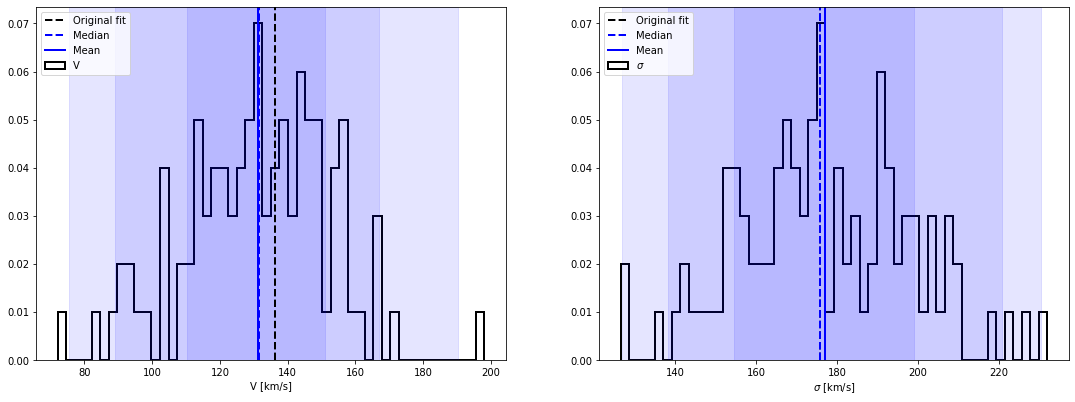

In [204]:
plot_boots(nit=100, sol_matrix=sol_matrix, orig_fit=orig_fit, save_path=save_path)